# BL40A2020 Wireless Communication Systems

## Assignment  week 6: Channel coding and information theory

## Author: Eero Suomalainen

In [1]:
! pip install scikit-dsp-comm
! pip install komm
! pip install sympy

In [2]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import ipywidgets
from scipy.stats import binom

### 1. Follow similar steps done in the [notes](https://github.com/pedrohjn/wireless-comm/blob/master/Week%206/week6.ipynb) to analyze the *[Binary erasure channel](https://komm.readthedocs.io/en/latest/komm.BinaryErasureChannel/)* 

![](https://upload.wikimedia.org/wikipedia/commons/b/b6/Binary_erasure_channel.svg)

**(a) Find the analytical error probability for a repetition code with size $n$ as a function of  $p$ considering that 0 and 1 are equally distributed?**

Hint: Remember that the only way to get an error in this scenario is to have all $n$ bits in the coded block wrong.

- Pr[receive 0 | transmit 0] = $1-p$
- Pr[receive e | transmit 0] = $p$
- Pr[receive 1 | transmit 1] = $1-p$
- Pr[receive e | transmit 1] = $p$
- Pr[receive e] = $p$

**With n repetitions**

- When every n repetition is wrong
- p = $p^n$

**(b) Verify your results with simulation for a repetition code of $n=6$ and $p=0.4$.** 

Hint: You need to program/adapt the decoding. The komm decoding for repetition code is based on the Majority rule, which is not suitable for BEC.

In [3]:
input_seq_size = 10000# sequence
tp = np.arange(0, input_seq_size , 1)
p_aux = 0.5 ## 0 and 1 are equally distributed
input_seq = np.random.choice([0, 1], size=input_seq_size, p=[p_aux, 1-p_aux])
p = 0.4
bec = komm.BinaryErasureChannel(p)
output_seq = bec(input_seq)
output_seq_coded = np.zeros(input_seq_size)
#####
#####
code_length = 6
rep_code = komm.RepetitionCode(code_length)
for i in range(input_seq_size):
    coded_input = rep_code.encode(input_seq[i])
    coded_bec = bec(coded_input)
    output_seq_coded[i] = rep_code.decode(coded_bec)
#####
count_uncoded = 0
count_coded = 0
for i in range(input_seq_size):
    if input_seq[i] != output_seq[i]:
        count_uncoded = count_uncoded + 1
    if input_seq[i] != output_seq_coded[i]:
        count_coded = count_coded + 1
print("Probability of error uncoded, Simulation:",count_uncoded/input_seq_size, "Analytical:", p)
print("Number of repetitions:", code_length)
if code_length % 2 == 0: ## % is the "mod" function - gives the "rest" in the division
    error_coded = 1 - (binom.cdf(code_length/2 - 1, code_length, p) + (binom.cdf(code_length/2, code_length, p) - binom.cdf(code_length/2-1, code_length, p))*0.5) #codelenght even number
else:
    error_coded = 1 - binom.cdf(code_length/2, code_length, p) 
print("Probability of error coded, Simulation:",count_coded/input_seq_size, "Analytical:", error_coded)

Probability of error uncoded, Simulation: 0.3963 Analytical: 0.4
Number of repetitions: 6
Probability of error coded, Simulation: 0.1812 Analytical: 0.31744000000000006


**(c) Compute the capacity of this channel.**

$I(X;Y) = H(X) - H(X|Y) = H (X) - \sum\limits_{y={\{0,1,e\}}} p(y) H(X \; | \; Y=y) = H (X) - pH(X \; | \; Y=e) = H (X) - pH(X) = H (X)(1-p)\leq 1-p$

**(d) Discuss how good is the repetition code in relation to the capacity based on a similar plot as the one presented in the tutorial.**

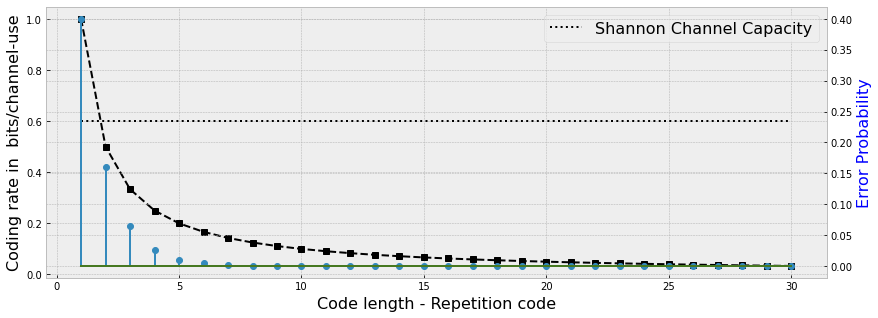

In [4]:
code_length_plot = np.arange(1,31,1)
#error_coded_plot = np.zeros(len(code_length_plot))
#for i in code_length_plot:
#    if i % 2 == 0: ## % is the "mod" function - gives the "rest" in the division
#        error_coded_plot[i-1] = 1 - (binom.cdf(i/2 - 1, i, p) + (binom.cdf(i/2, i, p) - binom.cdf(i/2-1, i, p))*0.5)
#    else:
#        error_coded_plot[i-1]  = 1 - binom.cdf(i/2, i, p)

####
fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1.twinx()
ax1.plot(code_length_plot, 1/code_length_plot,"ks--")
ax1.plot([1,30],[komm.BinaryErasureChannel(p).capacity(),komm.BinaryErasureChannel(p).capacity()] ,"k:",label='Shannon Channel Capacity')
ax2.stem(code_length_plot, p**code_length_plot)
ax1.set_xlabel('Code length - Repetition code',fontsize=16)
ax1.set_ylabel('Coding rate in  bits/channel-use', color='k',fontsize=16)
ax2.set_ylabel('Error Probability', color='b',fontsize=16)
ax1.legend(fontsize=16)
plt.show() 

**2. Evaluate the performance of the $M$-PSK in relation to Shannon capacity considering the symbol error probability: $$P \approx 2 Q \left(\sqrt{\dfrac{2 E_b \log_2 M}{N_0}} \sin\left(  \dfrac{\pi}{M} \right)  \right).$$**

**Consider the cases of $M=4,8,16$ and plot the figure $P$ versus $E_b/N_0$ in db. Additionally, plot the Shannon capacity vs. $E_b/N_0$.**

**Analyze with your own words the results.**

In [5]:
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

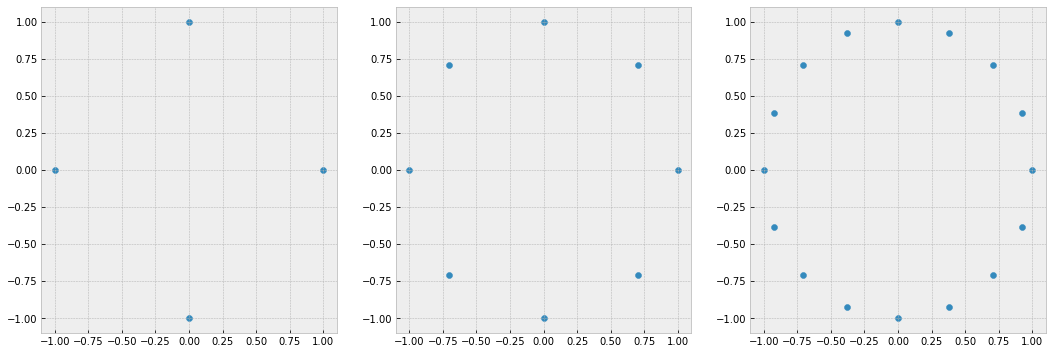

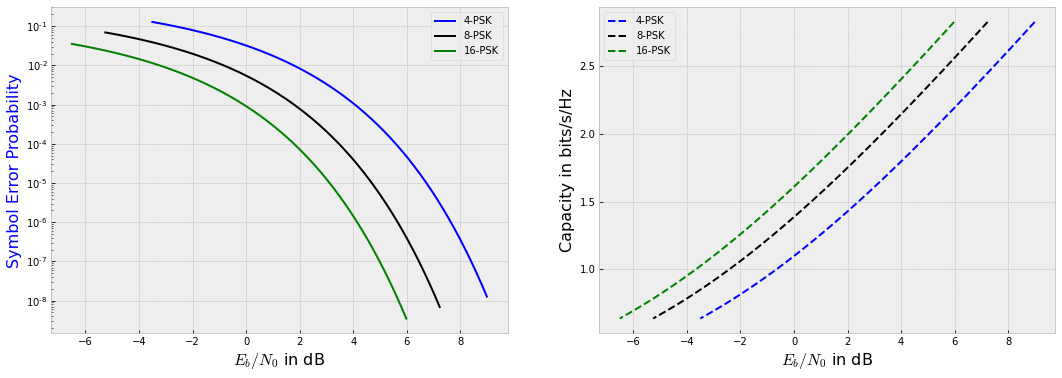

In [6]:
###################################
#4-PSK
base_amplitude = 1
awgn = komm.AWGNChannel()
noise_power_db_4psk = np.arange(-12, 0.5, 0.01)
noise_power_4psk = 10**(noise_power_db_4psk / 10)
order = 4
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_4psk  = modulation.energy_per_symbol
awgn.snr_4psk  = awgn.signal_power_4psk  / noise_power_4psk
EbperN0_4psk  = awgn.snr_4psk / modulation.bits_per_symbol
error_probability_4psk  = 2*Q(np.sqrt( 2* (np.log2(order)) * EbperN0_4psk))*sp.sin(sp.pi/order)
#
plt.figure(1,figsize=(18,6))
plt.subplot(131)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);
###################################
#8-PSK
base_amplitude = 1
noise_power_db_8psk = np.arange(-12, 0.5, 0.01)
noise_power_8psk = 10**(noise_power_db_8psk / 10)
order = 8
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_8psk  = modulation.energy_per_symbol
awgn.snr_8psk  = awgn.signal_power_8psk  / noise_power_8psk
EbperN0_8psk  = awgn.snr_8psk / modulation.bits_per_symbol
error_probability_8psk  = 2*Q(np.sqrt( 2* (np.log2(order)) * EbperN0_8psk))*sp.sin(sp.pi/order)
#
plt.subplot(132)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);
###################################
#16-PSK
base_amplitude = 1
noise_power_db_16psk = np.arange(-12, 0.5, 0.01)
noise_power_16psk = 10**(noise_power_db_16psk / 10)
order = 16
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_16psk  = modulation.energy_per_symbol
awgn.snr_16psk  = awgn.signal_power_16psk  / noise_power_16psk
EbperN0_16psk  = awgn.snr_16psk / modulation.bits_per_symbol
error_probability_16psk  = 2*Q(np.sqrt( 2* (np.log2(order)) * EbperN0_16psk))*sp.sin(sp.pi/order)
#
plt.subplot(133)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);
#
plt.show()

###
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log10(EbperN0_4psk), error_probability_4psk,'b',label='4-PSK');
plt.semilogy(10 * np.log10(EbperN0_8psk), error_probability_8psk,'k',label='8-PSK');
plt.semilogy(10 * np.log10(EbperN0_16psk), error_probability_16psk,'g',label='16-PSK');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

plt.subplot(122)
plt.plot(10 * np.log10(EbperN0_4psk), np.log(1+awgn.snr_4psk),'--b',label='4-PSK');
plt.plot(10 * np.log10(EbperN0_8psk), np.log(1+awgn.snr_8psk),'--k',label='8-PSK');
plt.plot(10 * np.log10(EbperN0_16psk), np.log(1+awgn.snr_16psk),'--g',label='16-PSK');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16);
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend();

#plt.figure(1,figsize=(18,6))
#plt.subplot(131)
#plt.scatter(modulation.constellation.real,modulation.constellation.imag);

#plt.subplot(132)
#plt.semilogy(10 * np.log10(EbperN0_4psk), error_probability_4psk,'k',label='4-PSK');
#plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
#plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
#plt.legend()

#plt.subplot(122)
#plt.plot(10 * np.log10(EbperN0_4psk), np.log(1+awgn.snr_4psk),'--k',label='4-PSK');
#plt.xlabel('$E_b/N_0$ in dB',fontsize=16);
#plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
#plt.legend();

With leftmost graph when Q in QPSK is higher probability for error and Eb/N0 is a bit lower. With rightmost graph capacity in bits is same between all Q values but with higher Q value Eb/N0 is lower when capacity is same.